PSN (Parametric Spectral Network) - Frequency-Aware Temporal Gating
Device: cuda

Loading UCI-HAR Dataset

############################################################
Loading UCI-HAR...
############################################################
Train: (7352, 128, 9) | Classes: 6
Test: (2947, 128, 9) | Classes: 6
Activity Names: ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']
Train class distribution: {np.int64(0): 1226, np.int64(1): 1073, np.int64(2): 986, np.int64(3): 1286, np.int64(4): 1374, np.int64(5): 1407}
Test class distribution: {np.int64(0): 496, np.int64(1): 471, np.int64(2): 420, np.int64(3): 491, np.int64(4): 532, np.int64(5): 537}

Successfully loaded 1 datasets



/tmp/ipython-input-2417384289.py:428: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Training UCI-HAR with Freq-Aware Gating PSN
Params: 0.31M | FLOPs: 35.32M | Inf: 6.98ms
Input: (128, 9) | Classes: 6
Epoch    LR         Loss       Acc        F1         Prec       Rec       
------------------------------------------------------------
1        0.001000   0.9734     0.8846     0.8825     0.8835     0.8825     (*)
2        0.000999   0.5739     0.9128     0.9131     0.9155     0.9135     (*)
3        0.000998   0.5302     0.9104     0.9121     0.9141     0.9114    
4        0.000996   0.5171     0.9287     0.9299     0.9320     0.9292     (*)
5        0.000994   0.5109     0.9311     0.9324     0.9337     0.9321     (*)
6        0.000991   0.5056     0.9335     0.9346     0.9382     0.9340     (*)
7        0.000988   0.5006     0.9321     0.9327     0.9366     0.9328    
8        0.000984   0.4971     0.9460     0.9469     0.9495     0.9467     (*)
9        0.000980   0.4957     0.9338     0.9340     0.9430     0.9339    
10       0.000976   0.4906     0.9518     0.952

/tmp/ipython-input-2417384289.py:295: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)


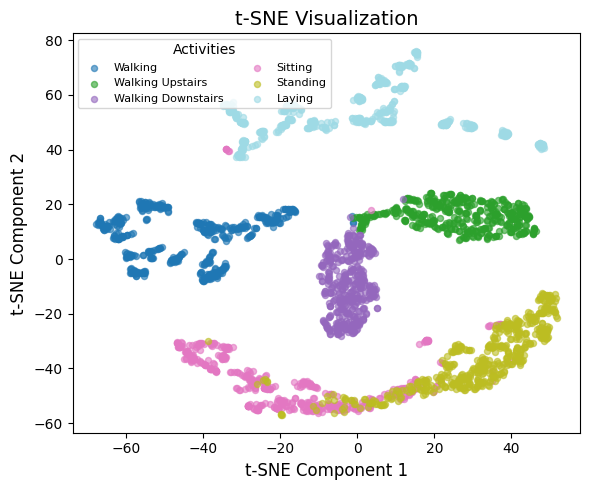

Generating Confusion Matrix for UCI-HAR...


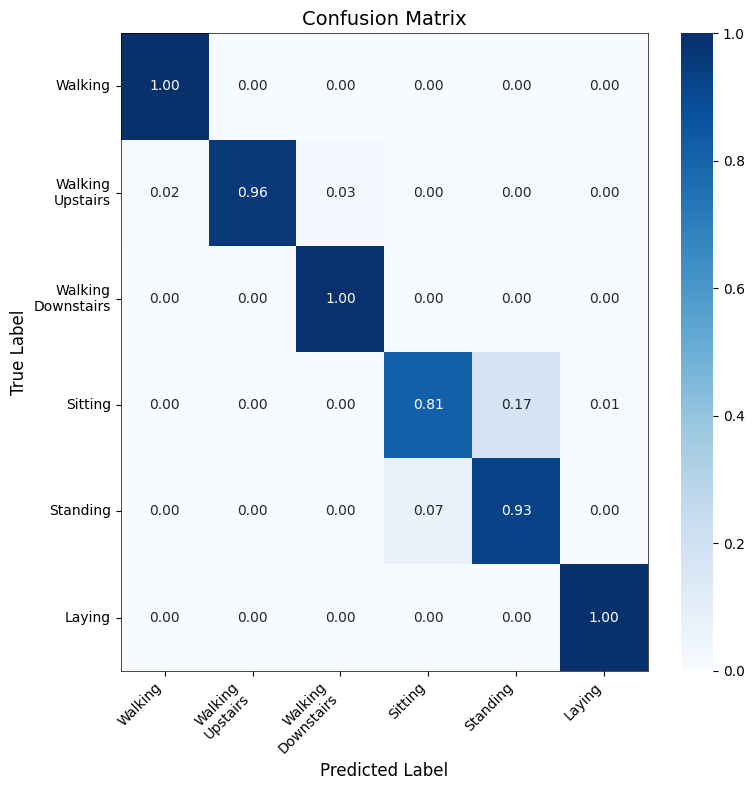


FINAL RESULTS

Dataset  Params(M)  FLOPs(M)  Inf(ms)    Acc     F1   Prec    Rec
UCI-HAR       0.31     35.32     6.98 0.9576 0.9583 0.9598 0.9579



In [8]:
!pip install thop ptflops

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from thop import profile
from collections import Counter
from glob import glob
import time
import os
import math
from torch.cuda.amp import GradScaler

class UCIHARDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def read_txt_matrix(file_path):
    return np.loadtxt(file_path)

def load_uci_har(root_path='/content/drive/MyDrive/HAR_Dataset/UCI'):
    UCI_CHANNELS_PREFIX = [
        "total_acc_x_", "total_acc_y_", "total_acc_z_",
        "body_acc_x_", "body_acc_y_", "body_acc_z_",
        "body_gyro_x_", "body_gyro_y_", "body_gyro_z_",
    ]
    def load_split(split):
        channels = []
        for prefix in UCI_CHANNELS_PREFIX:
            file_path = os.path.join(root_path, f"{prefix}{split}.txt")
            if not os.path.exists(file_path):
                raise FileNotFoundError(f"File not found: {file_path}")
            channels.append(read_txt_matrix(file_path))
        X = np.stack(channels, axis=1)
        y = read_txt_matrix(os.path.join(root_path, f"y_{split}.txt")).astype(int) - 1
        return X, y
    X_train, y_train = load_split('train')
    X_test, y_test = load_split('test')
    X_train = X_train.transpose(0, 2, 1)
    X_test = X_test.transpose(0, 2, 1)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    scaler = StandardScaler()
    scaler.fit(X_train_flat)
    X_train_flat = scaler.transform(X_train_flat)
    X_test_flat = scaler.transform(X_test_flat)
    X_train = X_train_flat.reshape(X_train.shape)
    X_test = X_test_flat.reshape(X_test.shape)
    activity_names = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']
    return X_train, y_train.astype(np.int64), X_test, y_test.astype(np.int64), activity_names

def load_wisdm_data(dataset_path="/content/drive/MyDrive/HAR_Dataset/WISDM"):
    return None, None, None, None, None

def load_opportunity_local_data(data_path="/content/drive/MyDrive/HAR_Dataset/OPPORTUNITY", window_size=30, step=15):
    return None, None, None, None, None

def load_dsads_data(data_path, w_s=25, stride=12):
    return None, None, None, None, None

def load_pamap2_data(dataset_dir="/content/drive/MyDrive/HAR_Dataset/PAMAP2"):
    return None, None, None, None, None

def load_mhealth_data(dataset_dir="/content/drive/MyDrive/HAR_Dataset/MHEALTH"):
    return None, None, None, None, None

class LearnedAdaptiveSpectralTransform(nn.Module):
    def __init__(self, seq_len, in_channels, num_basis=64):
        super().__init__()
        self.seq_len = seq_len
        self.in_channels = in_channels
        self.num_basis = num_basis
        self.register_buffer('t', torch.arange(seq_len).float())
        low_band = num_basis // 3
        mid_band = num_basis // 3
        high_band = num_basis - low_band - mid_band
        freqs_low = torch.linspace(0, seq_len//8, low_band) / seq_len
        freqs_mid = torch.linspace(seq_len//8, seq_len//4, mid_band) / seq_len
        freqs_high = torch.linspace(seq_len//4, seq_len//2, high_band) / seq_len
        init_freqs = torch.cat([freqs_low, freqs_mid, freqs_high])
        self.frequencies = nn.Parameter(init_freqs)
        self.phases = nn.Parameter(torch.zeros(num_basis))
        self.channel_weights_real = nn.Parameter(torch.randn(in_channels, num_basis) * 0.02)
        self.channel_weights_imag = nn.Parameter(torch.randn(in_channels, num_basis) * 0.02)
        self.gamma = nn.Parameter(torch.ones(in_channels, 1))
        self.beta = nn.Parameter(torch.zeros(in_channels, 1))

    def forward(self, x):
        B, C, T = x.shape
        args = 2 * np.pi * self.frequencies.unsqueeze(1) * self.t.unsqueeze(0) + self.phases.unsqueeze(1)
        basis_real = torch.cos(args)
        basis_imag = -torch.sin(args)
        spectral_real = torch.einsum('bct,ft->bcf', x, basis_real)
        spectral_imag = torch.einsum('bct,ft->bcf', x, basis_imag)
        weighted_real = spectral_real * (1 + self.channel_weights_real.unsqueeze(0)) - \
                       spectral_imag * self.channel_weights_imag.unsqueeze(0)
        weighted_imag = spectral_real * self.channel_weights_imag.unsqueeze(0) + \
                       spectral_imag * (1 + self.channel_weights_real.unsqueeze(0))
        spectral_mag = torch.sqrt(weighted_real**2 + weighted_imag**2 + 1e-8)
        spectral_mag = spectral_mag / math.sqrt(self.seq_len)
        spectral_mag = spectral_mag * self.gamma.unsqueeze(0) + self.beta.unsqueeze(0)
        return spectral_mag

class SpectralAttention(nn.Module):
    def __init__(self, num_basis, num_heads=4, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = num_basis // num_heads
        self.qkv = nn.Linear(num_basis, num_basis * 3)
        self.proj = nn.Linear(num_basis, num_basis)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(num_basis)
        self.temperature = nn.Parameter(torch.ones(1) * math.sqrt(self.head_dim))

    def forward(self, x):
        B, C, F_dim = x.shape
        outputs = []
        for c in range(C):
            x_c = x[:, c, :]
            x_norm = self.norm(x_c)
            qkv = self.qkv(x_norm).reshape(B, 3, self.num_heads, self.head_dim).permute(1, 0, 2, 3)
            q, k, v = qkv[0], qkv[1], qkv[2]
            attn = (q @ k.transpose(-2, -1)) / self.temperature
            attn = F.softmax(attn, dim=-1)
            attn = self.dropout(attn)
            out = (attn @ v).reshape(B, F_dim)
            out = self.proj(out)
            out = self.dropout(out)
            out = out + x_c
            outputs.append(out)
        return torch.stack(outputs, dim=1)

class EnhancedCrossDomainFusion(nn.Module):
    def __init__(self, hidden_dim, num_heads=4, dropout=0.1):
        super().__init__()
        self.cross_attn1 = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        self.cross_attn2 = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        self.gate = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Sigmoid()
        )
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Dropout(dropout)
        )
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)
        self.norm4 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, h_temporal, h_spectral):
        attn_ts, _ = self.cross_attn1(self.norm1(h_temporal), self.norm2(h_spectral), h_spectral)
        attn_st, _ = self.cross_attn2(self.norm3(h_spectral), self.norm4(h_temporal), h_temporal)
        h_t = h_temporal + self.dropout(attn_ts)
        h_s = h_spectral + self.dropout(attn_st)
        pooled_t = h_t.mean(dim=1)
        pooled_s = h_s.mean(dim=1)
        gate_input = torch.cat([pooled_t, pooled_s], dim=-1)
        gate_weight = self.gate(gate_input)
        fused = gate_weight * pooled_t + (1 - gate_weight) * pooled_s
        fused = fused + self.ffn(self.norm4(fused))
        return fused

class EnhancedTemporalEncoder(nn.Module):
    def __init__(self, in_channels, hidden_dim, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, hidden_dim, 3, padding=1)
        self.conv2 = nn.Conv1d(in_channels, hidden_dim, 5, padding=2)
        self.conv3 = nn.Conv1d(in_channels, hidden_dim, 7, padding=3)
        self.fusion_conv = nn.Conv1d(hidden_dim * 3, hidden_dim, 1)
        self.norm = nn.LayerNorm(hidden_dim)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Dropout(dropout)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h1 = F.relu(self.conv1(x))
        h2 = F.relu(self.conv2(x))
        h3 = F.relu(self.conv3(x))
        h = torch.cat([h1, h2, h3], dim=1)
        h = self.fusion_conv(h)
        h = h.transpose(1, 2)
        h = h + self.ffn(self.norm(h))
        return h

class EnhancedParametricSpectralHAR(nn.Module):
    def __init__(self, seq_len=128, in_channels=9, num_classes=6,
                 num_basis=64, hidden_dim=128, num_heads=4, dropout=0.1):
        super().__init__()
        self.spectral_operator = LearnedAdaptiveSpectralTransform(seq_len, in_channels, num_basis)
        self.spectral_conv = nn.Sequential(
            nn.Linear(num_basis, num_basis * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(num_basis * 2, num_basis)
        )
        self.spectral_attn = SpectralAttention(num_basis, num_heads, dropout)
        self.spectral_proj = nn.Linear(num_basis, hidden_dim)

        self.temporal_encoder = EnhancedTemporalEncoder(in_channels, hidden_dim, dropout)

        self.freq_aware_gate = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Sigmoid()
        )

        self.fusion = EnhancedCrossDomainFusion(hidden_dim, num_heads, dropout)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
        self.hidden_dim = hidden_dim

    def forward(self, x):
        x = x.transpose(1, 2)
        B, C, T = x.shape

        spectral = self.spectral_operator(x)
        spectral = self.spectral_conv(spectral)
        spectral = self.spectral_attn(spectral)
        spectral_pooled = spectral.mean(dim=1)
        spectral_emb = self.spectral_proj(spectral_pooled)

        temporal = self.temporal_encoder(x)

        gate_signal = self.freq_aware_gate(spectral_emb).unsqueeze(1)
        temporal_gated = temporal * gate_signal

        spectral_expanded = spectral_emb.unsqueeze(1).expand(B, temporal_gated.size(1), -1)
        fused = self.fusion(temporal_gated, spectral_expanded)
        logits = self.classifier(fused)
        return logits

    def extract_features(self, x):
        x = x.transpose(1, 2)
        B, C, T = x.shape
        spectral = self.spectral_operator(x)
        spectral = self.spectral_conv(spectral)
        spectral = self.spectral_attn(spectral)
        spectral_pooled = spectral.mean(dim=1)
        spectral_emb = self.spectral_proj(spectral_pooled)
        temporal = self.temporal_encoder(x)
        gate_signal = self.freq_aware_gate(spectral_emb).unsqueeze(1)
        temporal_gated = temporal * gate_signal
        spectral_expanded = spectral_emb.unsqueeze(1).expand(B, temporal_gated.size(1), -1)
        fused = self.fusion(temporal_gated, spectral_expanded)
        return fused

def plot_tsne(features, labels, activity_names, save_path, samples_per_class=600):
    sampled_features, sampled_labels = [], []
    for i in range(len(activity_names)):
        class_mask = (labels == i)
        class_indices = np.where(class_mask)[0]
        if len(class_indices) > 0:
            if len(class_indices) >= samples_per_class:
                selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)
            else:
                selected_indices = class_indices
            sampled_features.append(features[selected_indices])
            sampled_labels.append(labels[selected_indices])
    features_sampled = np.vstack(sampled_features)
    labels_sampled = np.concatenate(sampled_labels)
    n_samples = features_sampled.shape[0]
    perplexity = min(30, n_samples - 1)
    features_2d = TSNE(n_components=2, perplexity=perplexity, learning_rate=200, random_state=42).fit_transform(features_sampled)
    num_classes = len(activity_names)
    cmap = plt.cm.get_cmap('tab20', num_classes)
    colors = [cmap(i) for i in range(num_classes)]
    plt.figure(figsize=(6, 5))
    for i, activity in enumerate(activity_names):
        mask = (labels_sampled == i)
        if np.any(mask):
            plt.scatter(features_2d[mask, 0], features_2d[mask, 1],
                       color=colors[i], marker='o', s=19, alpha=0.6, label=activity)
    plt.legend(title="Activities", fontsize=8, loc='best', ncol=2)
    plt.xlabel("t-SNE Component 1", fontsize=12)
    plt.ylabel("t-SNE Component 2", fontsize=12)
    plt.title("t-SNE Visualization", fontsize=14)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def plot_confusion_matrix(cm, activity_names, save_path):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    num_classes = len(activity_names)
    labels = []
    for name in activity_names:
        if len(name) > 15:
            words = name.split()
            if len(words) > 1:
                mid = len(words) // 2
                labels.append(' '.join(words[:mid]) + '\n' + ' '.join(words[mid:]))
            else:
                labels.append(name[:15] + '\n' + name[15:])
        else:
            labels.append(name)
    df = pd.DataFrame(cm_normalized, index=labels, columns=labels)
    annot = df.copy().astype(str)
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            v = df.iloc[i, j]
            annot.iloc[i, j] = f"{v:.2f}"
    figsize = max(8, num_classes * 0.5)
    plt.figure(figsize=(figsize, figsize))
    sns.heatmap(df, annot=annot.values, fmt="", cmap="Blues", cbar=True,
                annot_kws={"size": max(6, 12 - num_classes // 3)}, vmin=0, vmax=1)
    plt.xticks(rotation=45, ha='right', fontsize=max(6, 11 - num_classes // 4))
    plt.yticks(rotation=0, fontsize=max(6, 11 - num_classes // 4))
    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.5)
        spine.set_edgecolor('black')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def evaluate(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            logits = model(batch_x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    return acc, f1, precision, recall

def extract_features_and_predictions(model, data_loader, device):
    model.eval()
    all_features, all_preds, all_labels = [], [], []
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            features = model.extract_features(batch_x)
            logits = model(batch_x)
            preds = torch.argmax(logits, dim=1)
            all_features.append(features.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    return np.vstack(all_features), np.array(all_preds), np.array(all_labels)

def compute_flops_params(model, input_shape, device):
    model.eval()
    dummy_input = torch.randn(1, *input_shape).to(device)
    macs, params = profile(model, inputs=(dummy_input,), verbose=False)
    flops_m = macs * 2 / 1e6
    params_m = params / 1e6
    return flops_m, params_m

def measure_inference_time(model, input_shape, device, n_runs=100, warmup=10):
    model.eval()
    dummy_input = torch.randn(1, *input_shape).to(device)
    with torch.no_grad():
        for _ in range(warmup):
            _ = model(dummy_input)
    if device.type == 'cuda':
        torch.cuda.synchronize()
    start = time.time()
    with torch.no_grad():
        for _ in range(n_runs):
            _ = model(dummy_input)
    if device.type == 'cuda':
        torch.cuda.synchronize()
    end = time.time()
    return (end - start) / n_runs * 1000

def train_single_dataset(dataset_name, X_train, y_train, X_test, y_test, activity_names, device, epochs=100):
    seq_len = X_train.shape[1]
    input_dim = X_train.shape[2]
    num_classes = len(np.unique(y_train))
    train_dataset = UCIHARDataset(X_train, y_train)
    test_dataset = UCIHARDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)
    model = EnhancedParametricSpectralHAR(
        seq_len=seq_len,
        in_channels=input_dim,
        num_classes=num_classes,
        num_basis=64,
        hidden_dim=128,
        num_heads=4,
        dropout=0.2
    ).to(device)
    flops_m, params_m = compute_flops_params(model, (seq_len, input_dim), device)
    inf_time = measure_inference_time(model, (seq_len, input_dim), device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    scaler = GradScaler()
    best_acc = 0.0
    best_metrics = {}
    best_model_state = None
    print(f"\n{'='*60}")
    print(f"Training {dataset_name} with Freq-Aware Gating PSN")
    print(f"{'='*60}")
    print(f"Params: {params_m:.2f}M | FLOPs: {flops_m:.2f}M | Inf: {inf_time:.2f}ms")
    print(f"Input: ({seq_len}, {input_dim}) | Classes: {num_classes}")
    print(f"{'Epoch':<8} {'LR':<10} {'Loss':<10} {'Acc':<10} {'F1':<10} {'Prec':<10} {'Rec':<10}")
    print("-" * 60)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                logits = model(batch_x)
                loss = criterion(logits, batch_y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()
        scheduler.step()
        test_acc, test_f1, test_prec, test_rec = evaluate(model, test_loader, device)
        if test_acc > best_acc:
            best_acc = test_acc
            best_metrics = {
                'acc': test_acc,
                'f1': test_f1,
                'prec': test_prec,
                'rec': test_rec
            }
            best_model_state = model.state_dict().copy()
            best_msg = " (*)"
        else:
            best_msg = ""
        current_lr = optimizer.param_groups[0]['lr']
        print(f"{epoch+1:<8} {current_lr:<10.6f} {total_loss/len(train_loader):<10.4f} "
              f"{test_acc:<10.4f} {test_f1:<10.4f} {test_prec:<10.4f} {test_rec:<10.4f}{best_msg}")
    print("-" * 60)
    print(f"Best - Acc: {best_metrics['acc']:.4f} | F1: {best_metrics['f1']:.4f} | Prec: {best_metrics['prec']:.4f} | Rec: {best_metrics['rec']:.4f}")
    print(f"Params: {params_m:.2f}M | FLOPs: {flops_m:.2f}M | Inf: {inf_time:.2f}ms")
    model.load_state_dict(best_model_state)
    features, preds, labels = extract_features_and_predictions(model, test_loader, device)
    cm = confusion_matrix(labels, preds)
    tsne_path = f"{dataset_name}_PSN_tsne.png"
    cm_path = f"{dataset_name}_PSN_confusion_matrix.png"
    print(f"\nGenerating t-SNE plot for {dataset_name}...")
    plot_tsne(features, labels, activity_names, tsne_path)
    print(f"Generating Confusion Matrix for {dataset_name}...")
    plot_confusion_matrix(cm, activity_names, cm_path)
    return {
        'Dataset': dataset_name,
        'Params(M)': round(params_m, 2),
        'FLOPs(M)': round(flops_m, 2),
        'Inf(ms)': round(inf_time, 2),
        'Acc': round(best_metrics['acc'], 4),
        'F1': round(best_metrics['f1'], 4),
        'Prec': round(best_metrics['prec'], 4),
        'Rec': round(best_metrics['rec'], 4)
    }

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("=" * 80)
    print("PSN (Parametric Spectral Network) - Frequency-Aware Temporal Gating")
    print("=" * 80)
    print(f"Device: {device}\n")
    datasets_config = [
        ('UCI-HAR', load_uci_har, '/content/drive/MyDrive/HAR_Dataset/UCI'),
    ]
    all_datasets = {}
    print("=" * 80)
    print("Loading UCI-HAR Dataset")
    print("=" * 80)
    for dataset_name, loader_func, data_path in datasets_config:
        try:
            print(f"\n{'#'*60}")
            print(f"Loading {dataset_name}...")
            print(f"{'#'*60}")
            data = loader_func(data_path)
            if data is None or data[0] is None:
                print(f"Failed to load {dataset_name}")
                continue
            X_train, y_train, X_test, y_test, activity_names = data
            num_train_classes = len(np.unique(y_train))
            num_test_classes = len(np.unique(y_test))
            print(f"Train: {X_train.shape} | Classes: {num_train_classes}")
            print(f"Test: {X_test.shape} | Classes: {num_test_classes}")
            print(f"Activity Names: {activity_names}")
            train_class_dist = Counter(y_train)
            test_class_dist = Counter(y_test)
            print(f"Train class distribution: {dict(sorted(train_class_dist.items()))}")
            print(f"Test class distribution: {dict(sorted(test_class_dist.items()))}")
            all_datasets[dataset_name] = {
                'X_train': X_train,
                'y_train': y_train,
                'X_test': X_test,
                'y_test': y_test,
                'activity_names': activity_names
            }
        except Exception as e:
            print(f"Error loading {dataset_name}: {e}")
            import traceback
            traceback.print_exc()
            continue
    print(f"\n{'='*80}")
    print(f"Successfully loaded {len(all_datasets)} datasets")
    print(f"{'='*80}\n")
    results = []
    for dataset_name, dataset_data in all_datasets.items():
        try:
            result = train_single_dataset(
                dataset_name,
                dataset_data['X_train'],
                dataset_data['y_train'],
                dataset_data['X_test'],
                dataset_data['y_test'],
                dataset_data['activity_names'],
                device,
                epochs=100
            )
            results.append(result)
        except Exception as e:
            print(f"Error training {dataset_name}: {e}")
            import traceback
            traceback.print_exc()
            continue
    if results:
        print(f"\n{'='*80}")
        print("FINAL RESULTS")
        print(f"{'='*80}\n")
        results_df = pd.DataFrame(results)
        results_df = results_df[['Dataset', 'Params(M)', 'FLOPs(M)', 'Inf(ms)', 'Acc', 'F1', 'Prec', 'Rec']]
        print(results_df.to_string(index=False))
        print(f"\n{'='*80}")